# An Analysis of LendingClub Data to Forecast Demand and Predict Risk of Loans
Thomas Munduchira, Sulli Vo, Dannie Vo, Ricardo Rendon Reynoso, Sarah Rahman

## Introduction
LendingClub is a peer to peer lending company in which their product allows consumers to both invest and borrow loans. They offer multiple kinds of loans like student loans, personal loans, auto refinancing loans and even business loans. The borrowers who are interested in obtaining loans will get a loan grade assigned to them which affect their interest rates and the amount of money they can borrow. A lot of the LendingClub data leads to insightful conclusions about the borrowing and investing patterns of all kinds of individuals. Through our investigation, we will explain patterns and similarities of the behaviors of borrowers and investors.   

## Questions of Interest
We intend to start off with exploratory data analysis of all the factors involved to find patterns and relationships. We will look at the data from multiple angles to get a sense of the intricacies that lie within the data. We will additionally match the trend we see in the data to external events to try to explain why such is happening.

We will also conduct time series decomposition in regards to the average loan amounts being requested. We will take a look at the trend and the seasonality so that we can better forecast spikes in demand.

After, we will try to fit prediction models in order to answer a couple questions: namely whether a loan request from a client should be funded or not and what interest rate a client should get based off the data we have on them. After finding good models, we will deconstruct them in order to get a deeper sense of the important aspects in such decisions.

## Dataset
The dataset we are using is a compilation of data on loans issued by LendingClub from the period 2007 to 2015. The data includes information on the current loan status (how much has been funded so far, how much has been paid off, etc) as well as information about the borrower (occupation, income, credit score, etc). This data lends itself to a variety of interesting financial analysis, notably time series analysis since the data is date stamped.

More information about the dataset can be found here: https://www.kaggle.com/wendykan/lending-club-loan-data.

In [86]:
import datetime
import math
import random
import time
import warnings

import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, metrics, model_selection, preprocessing, tree
from sklearn.datasets import fetch_mldata
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import label_binarize, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import statsmodels.formula.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')

cols_to_use = list(range(2, 9)) + list(range(10, 14)) + list(range(15, 17)) + [20, 23, 26, 30, 38] + list(range(45, 48)) + [52, 58, 64, 105, 114, 137]
data = pd.read_csv("loan.csv", usecols=cols_to_use)
data['issue_date'] = pd.to_datetime(data['issue_d'], format='%b-%Y')
data['issue_year'] = list(map(lambda issue_date: issue_date.year, data['issue_date']))
data['issue_month'] = list(map(lambda issue_date: issue_date.month, data['issue_date']))

In [96]:
%load_ext rpy2.ipython

In [98]:
%%R -w 5 -h 5 --units in -r 200

set.seed(50)

options(scipen=999)

library(data.table)
library(gapminder)
library(ggplot2)
library(magrittr)
library(maps)
library(plotly)
library(plyr)
library(tidyr)
library(zoo)

data <- fread("loan.csv", sep = ",", fill = FALSE, select = c(3:9, 11:14, 16:17, 21, 24, 27, 31, 39, 46:48, 53, 59, 65, 106, 115, 138))
data$issue_year = year(as.yearmon(data$issue_d, "%b-%Y"))
data$issue_month = month(as.yearmon(data$issue_d, "%b-%Y"))

## Data Exploration

In [87]:
data.shape

(2260668, 30)

In [88]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,next_pymnt_d,application_type,tot_cur_bal,total_bal_il,pub_rec_bankruptcies,sec_app_mort_acc,disbursement_method,issue_date,issue_year,issue_month
0,2500,2500,2500.0,36 months,13.56,84.92,C,Chef,10+ years,RENT,...,Mar-2019,Individual,16901.0,12560.0,1.0,NaN,Cash,2018-12-01,2018,12
1,30000,30000,30000.0,60 months,18.94,777.23,D,Postmaster,10+ years,MORTGAGE,...,Mar-2019,Individual,321915.0,87153.0,1.0,NaN,Cash,2018-12-01,2018,12
2,5000,5000,5000.0,36 months,17.97,180.69,D,Administrative,6 years,MORTGAGE,...,Mar-2019,Individual,110299.0,7150.0,0.0,NaN,Cash,2018-12-01,2018,12
3,4000,4000,4000.0,36 months,18.94,146.51,D,IT Supervisor,10+ years,MORTGAGE,...,Mar-2019,Individual,305049.0,30683.0,0.0,NaN,Cash,2018-12-01,2018,12
4,30000,30000,30000.0,60 months,16.14,731.78,C,Mechanic,10+ years,MORTGAGE,...,Mar-2019,Individual,116007.0,28845.0,0.0,NaN,Cash,2018-12-01,2018,12


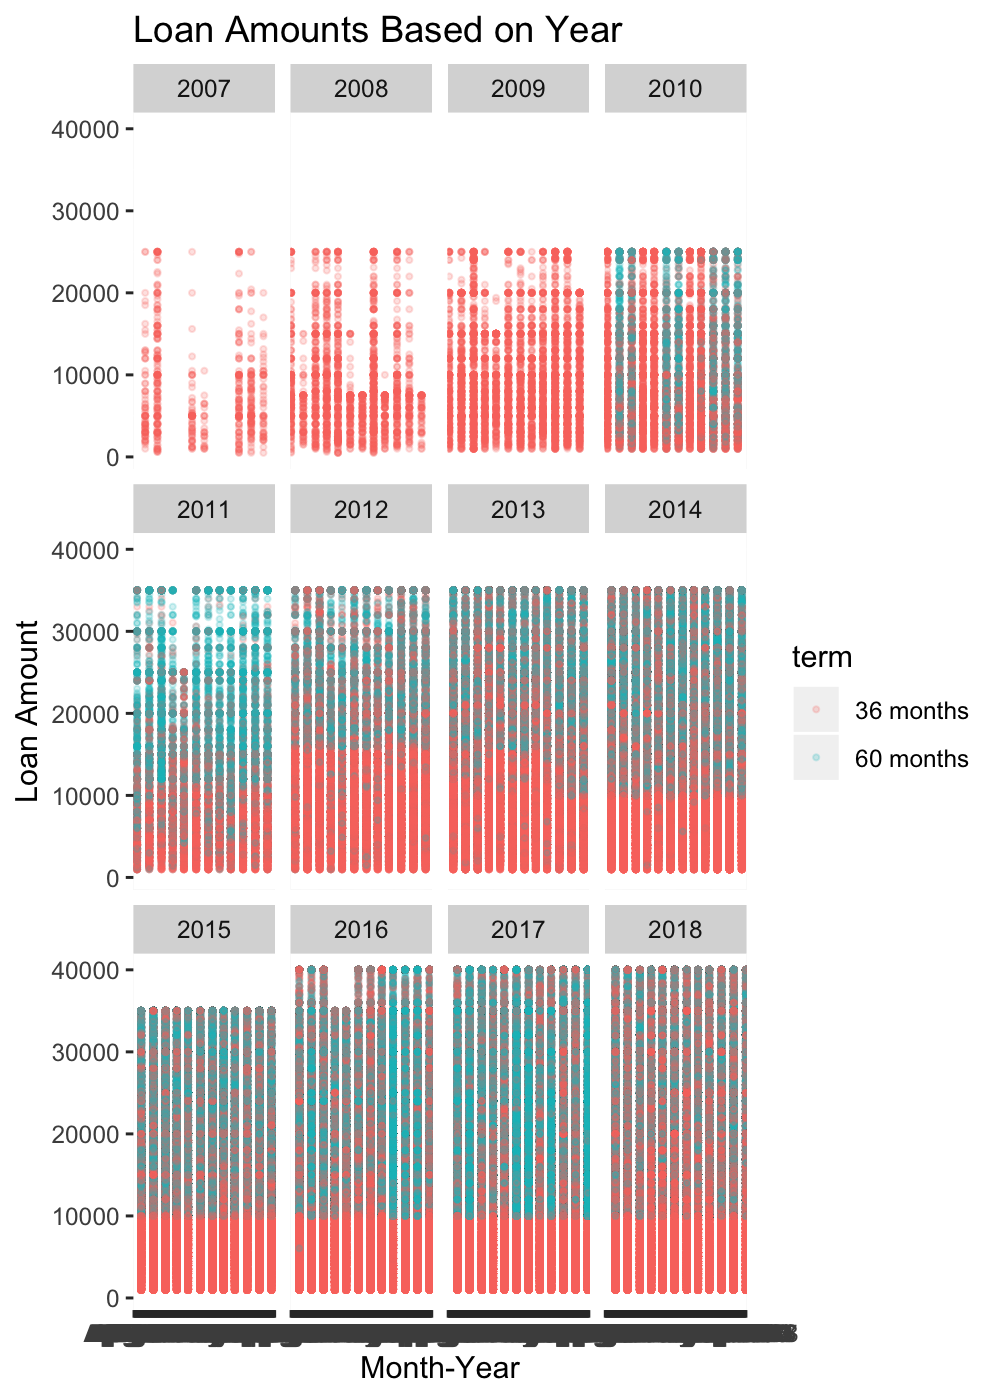

In [40]:
%%R -w 5 -h 7 --units in -r 200

ggplot(data, aes(x = issue_d, y = loan_amnt, color = term)) +
xlab("Month-Year") +
ylab("Loan Amount") +
ggtitle("Loan Amounts Based on Year") +
geom_point(alpha = 1/5, size = 0.7) +
facet_wrap(~issue_year)

Based on the plot above, we can see that loan amounts are usually below 25,000 until 2011, when it goes as high as 35,000. This remains the case until 2016, at which point requests went beyond 40,000. This is likely not a trend, but just a factor of what the bank has accepted as a request over time.

During 2007 to 2009, the loans all had 36 month payment plans, but people started borrowing loans with 60 month payment plans from 2010 onwards. This is due to the bank not offering 60 month payment plans at the time. It can also be seen that loans with higher amounts requested are much more likely to have 60 month payment plans. The loan amount threshold for this gradient seems to be 10,000.

Online sources such as pmifunds.com, show a similar trend. Peer-to peer loan increases in popularity from late 2011 to early 2012. 2017 marks the year with the highest amount of 60 month loans as indicated by the amount of blue on the graphs.

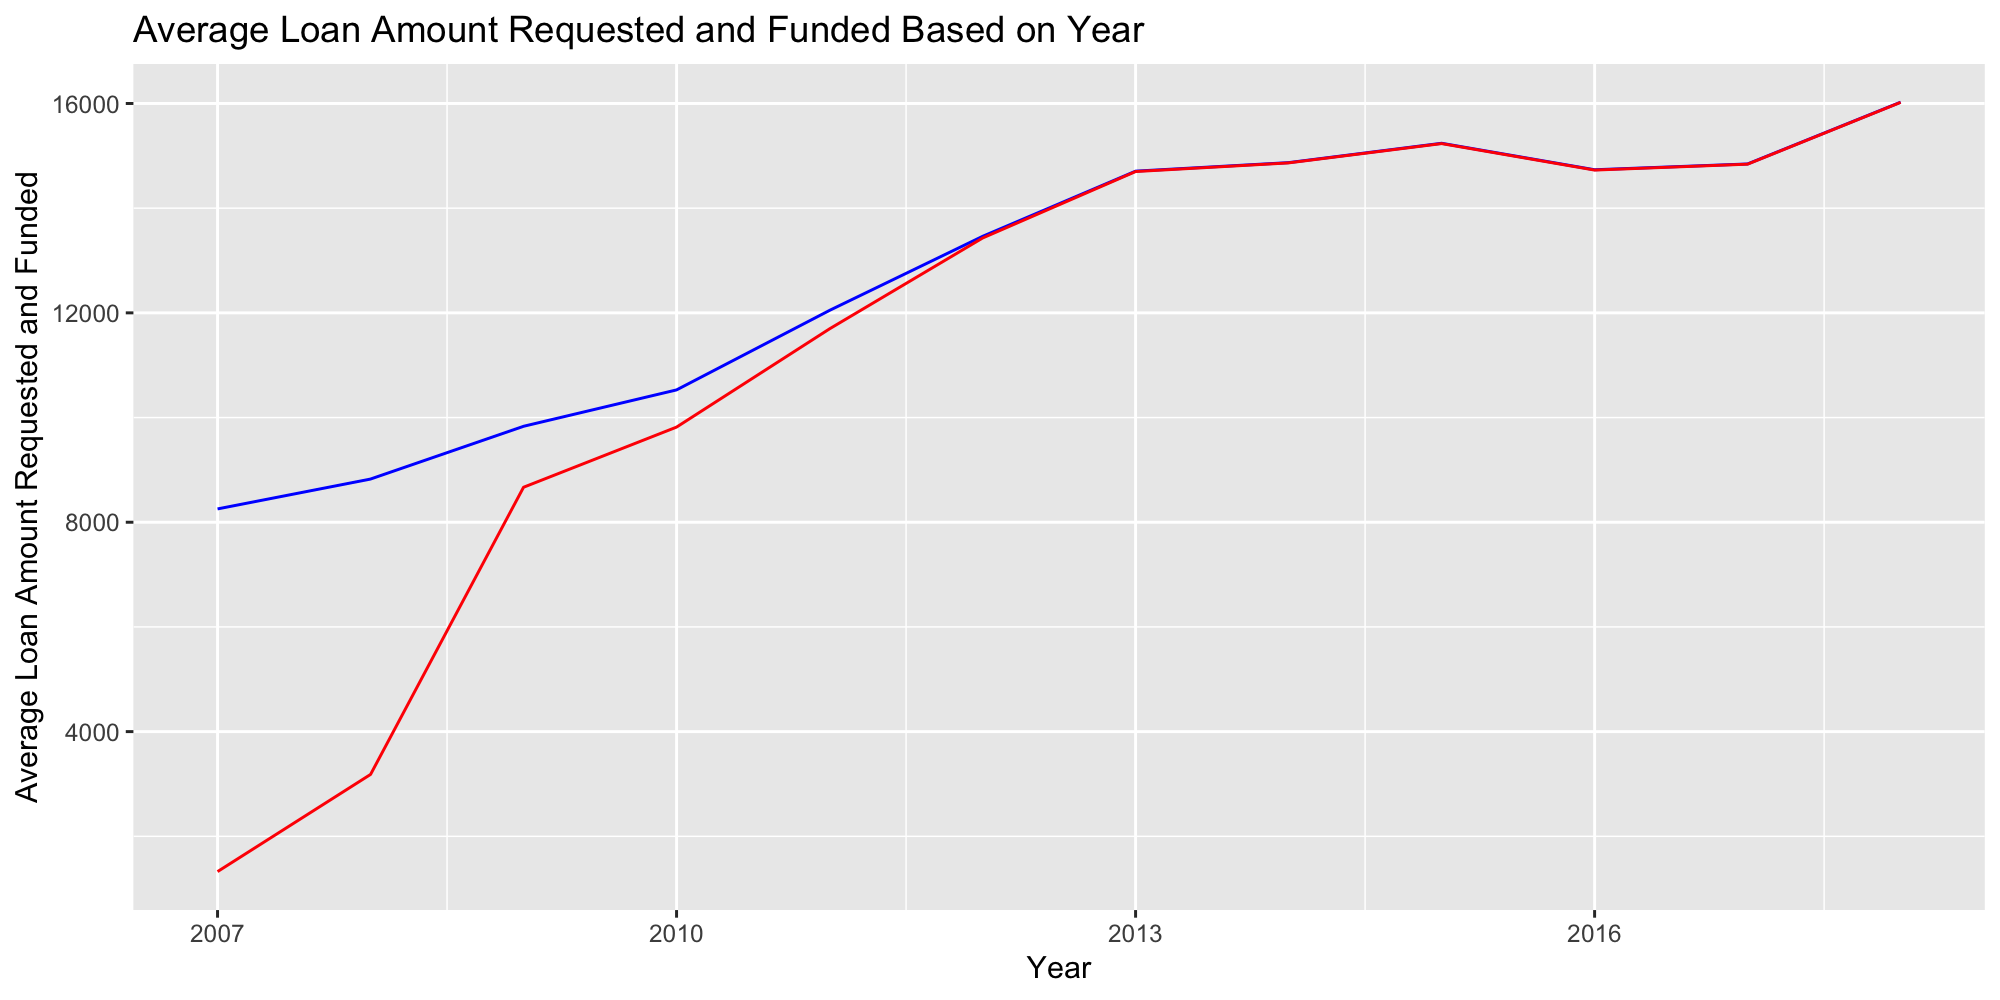

In [41]:
%%R -w 10 -h 5 --units in -r 200

ave_loan_amnt = aggregate(loan_amnt ~ issue_year, data, FUN = mean, na.rm = TRUE)
avg_funded_amt_inv = aggregate(funded_amnt_inv ~ issue_year, data, FUN = mean, na.rm = TRUE)
join_by_year <- merge(ave_loan_amnt, avg_funded_amt_inv, by = "issue_year")

ggplot(join_by_year, aes(x = issue_year)) +
geom_line(aes(y = loan_amnt), colour = "blue") +
geom_line(aes(y = funded_amnt_inv), colour = "red") +
ylab("Average Loan Amount Requested and Funded") +
xlab("Year") +
ggtitle("Average Loan Amount Requested and Funded Based on Year")

The plot above shows the average amount of loan requested (in blue) and the amount of loan funded (in red) by investors each year. The average loan amount is on the rise with the exception of the 2015-2016 period. Moreover, the loan amount funded is less than the requested loan amount from 2007-2012. This shows that it is getting easier to receive loans later on.

Note that the loans requeted and loans funded lines converge around 2012, where from that point forward all the loans requested are equally funded. The years 2013-2017 have barely any increase in loans requested or funded.

Notice the spike in the graph between 2008-2009, where the rate of the amount of loans funded increases. This can be attributed to the housing market crash during this time, where there was a trend of buying houses throughout America. The increase in buying houses is a possible cause for this spike, but further evidence and investigation is needed to conclude causation.

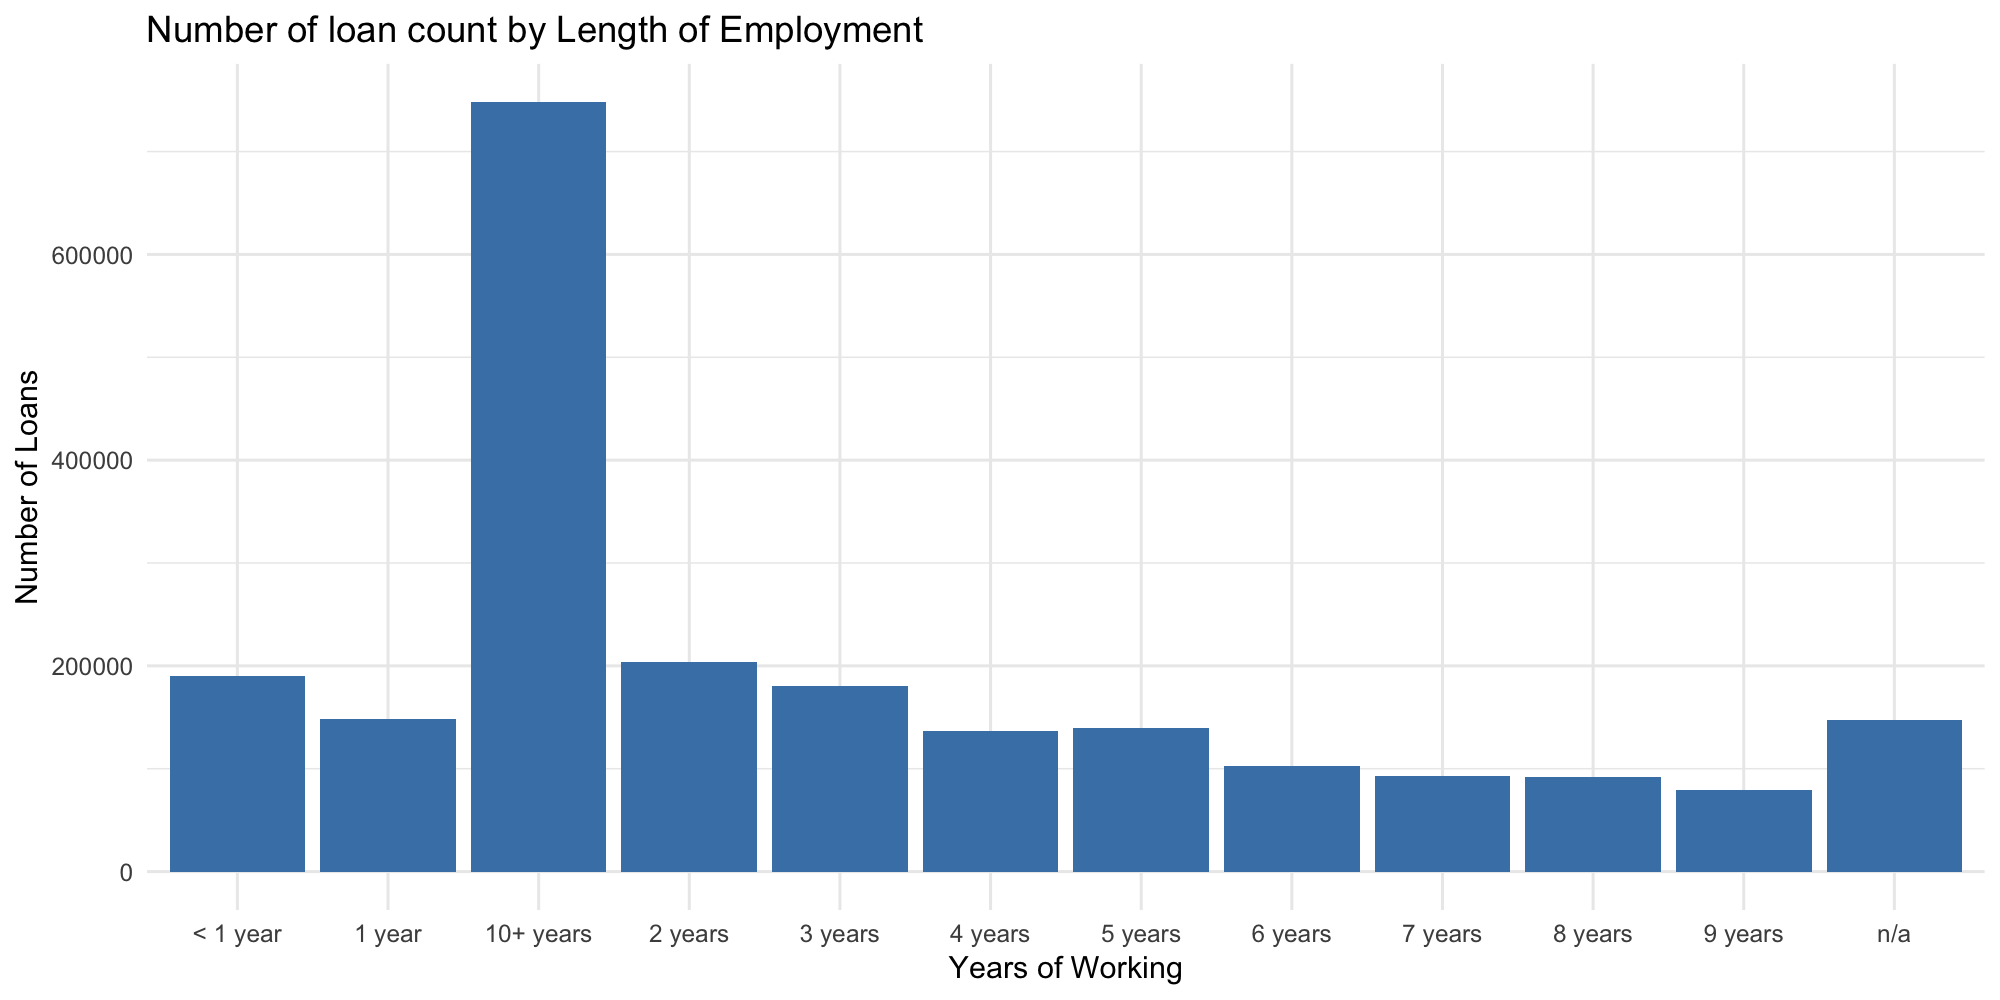

In [42]:
%%R -w 10 -h 5 --units in -r 200

emp_length_count = as.data.frame(data %>% dplyr::count(emp_length, sort = TRUE))
ggplot(emp_length_count, aes(x = emp_length_count$emp_length, y = emp_length_count$n)) +
geom_bar(stat="identity", fill="steelblue") +
theme_minimal() + 
ylab("Number of Loans") +
xlab("Years of Working") +
ggtitle("Number of loan count by Length of Employment")

It can be seen that as work experience increases, people are slightly less likely to request loans. With the exception of the first 3 categories, from 2 years on there is a decrease in the nuber of loans requested. However, people with 10+ years of work experience tend to ask for considerably more loans. One possible cause for this is the category of 10+ is taking into account a bigger range (10 years to potentially infinite years) , whereas the other categories are only a range of one year. Because of this, it is difficult to conclude the start difference in the 10+ years category as significant.

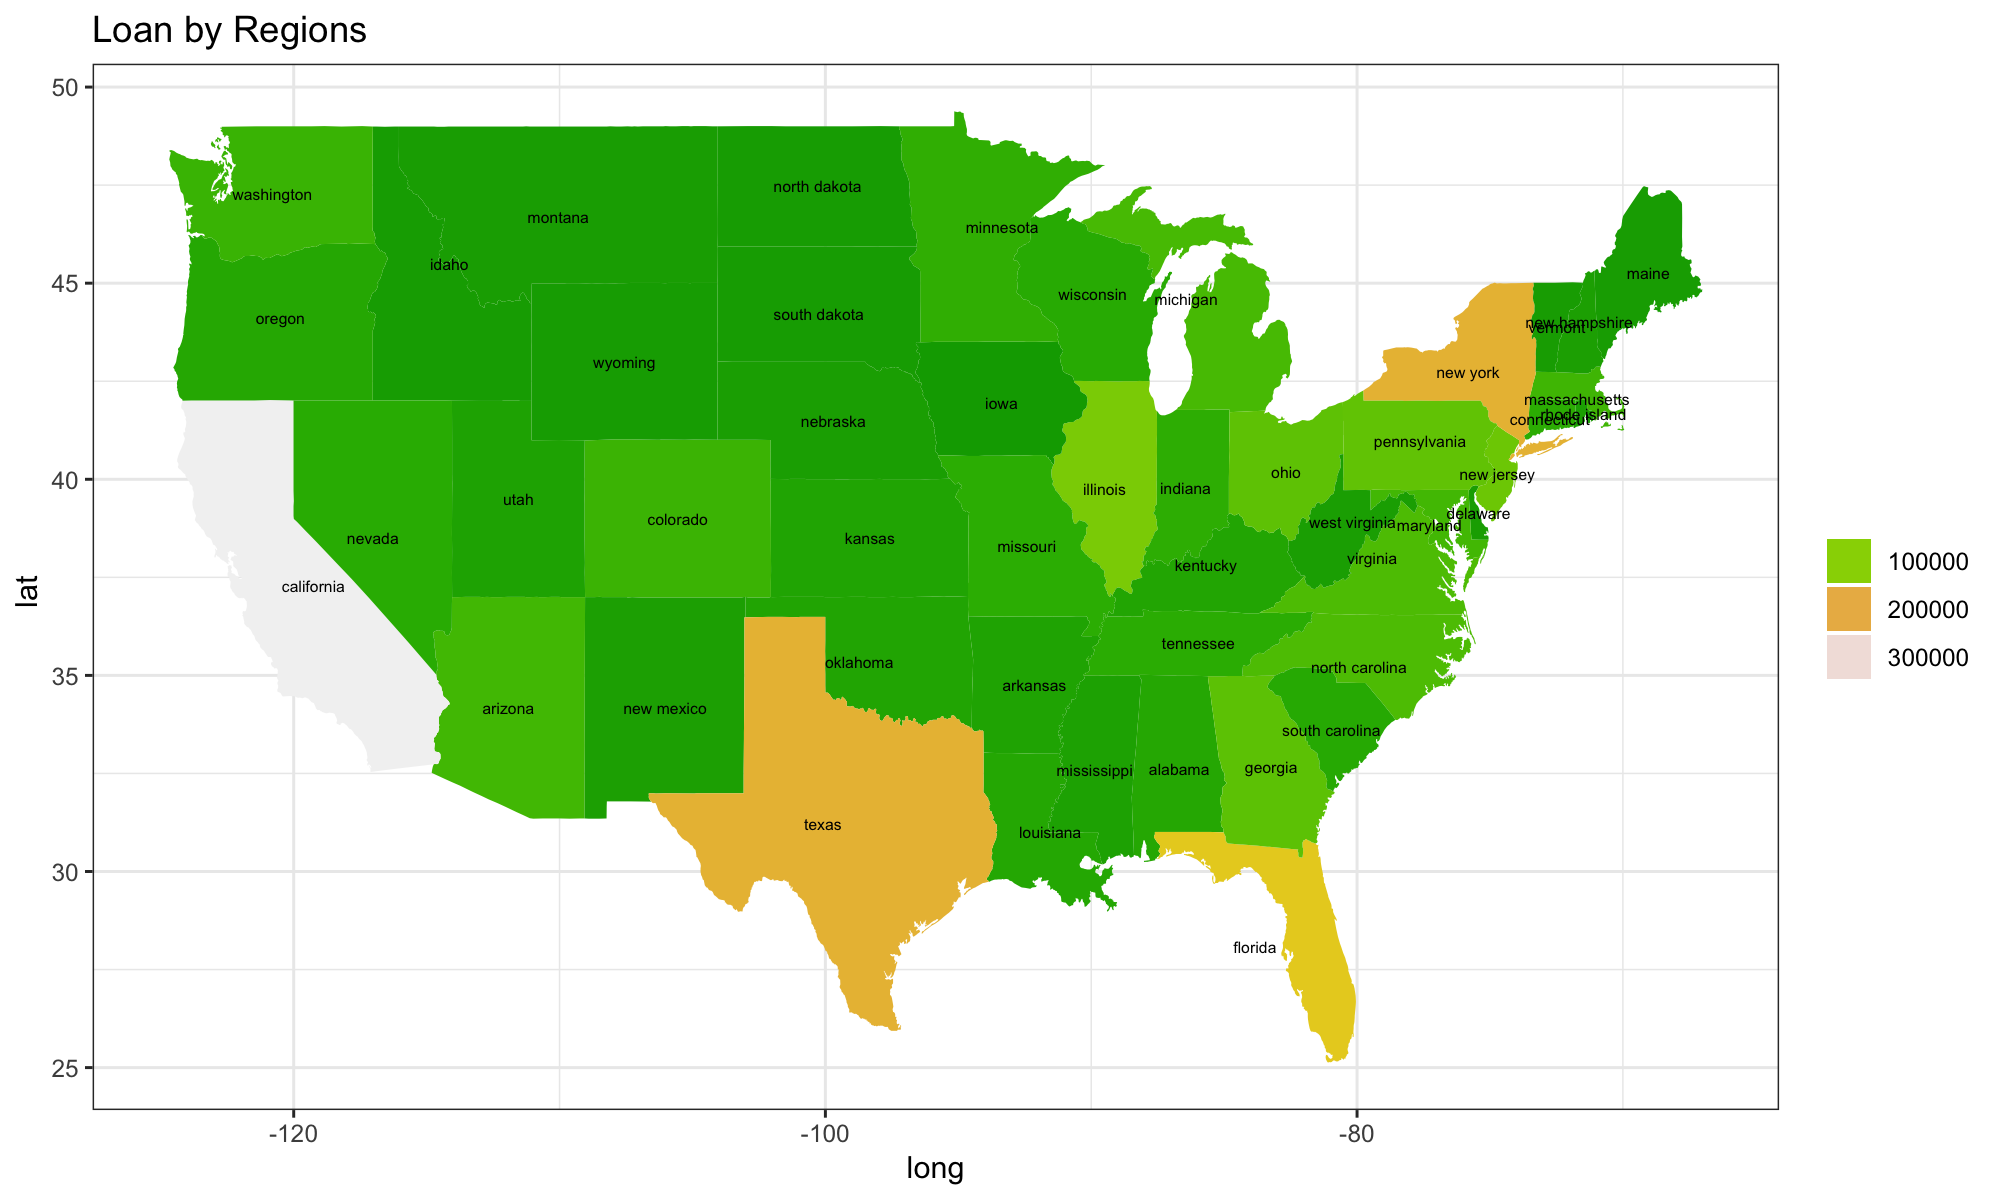

In [43]:
%%R -w 10 -h 6 --units in -r 200

a <- group_by(data, addr_state) %>% dplyr::count(addr_state) %>% set_colnames(c("region","count"))
a$region = sapply(state.name[match(a$region, state.abb)], tolower)
all_states <- map_data("state")
b <- merge(all_states, a, by = "region")
cnames <- aggregate(cbind(long, lat) ~ region, data = b, FUN = function(x) mean(range(x)))
                    
ggplot(b, aes(x = long, y = lat, map_id = region)) +
geom_map(aes(fill = count), map = all_states) + labs(title = "Loan by Regions", x = "long", y = "lat ") +
scale_fill_gradientn("", colours = terrain.colors(10), guide = "legend") +
geom_text(data = cnames, aes(long, lat, label = region), size = 2) +
theme_bw()

California has the most people asking for a loan. Texas and New York are the next biggest in terms of the number of people requesting loans. The 2019 consensus reveals that California is the most populated state, followed by Texas, Florida and New York. Since these regions are some of the most populous in the United States, it is understandable that they have the highest number of loan requests.

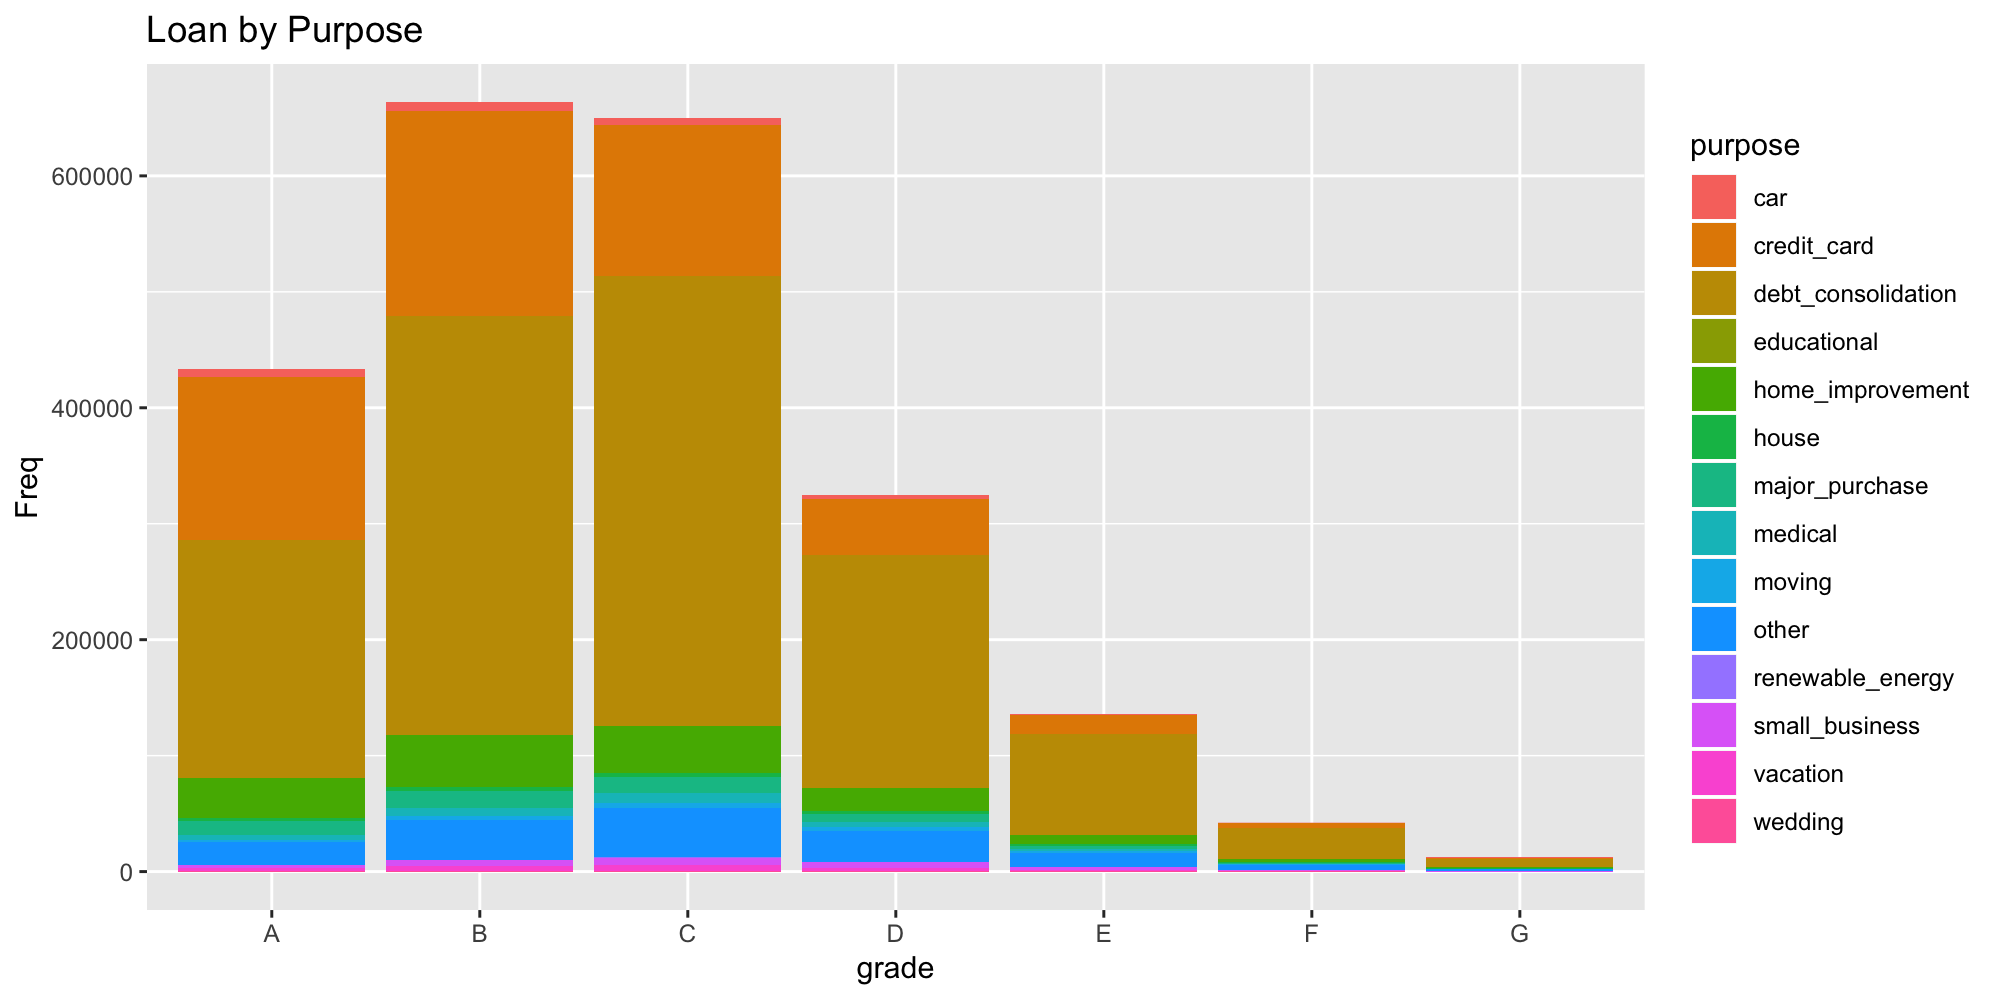

In [44]:
%%R -w 10 -h 5 --units in -r 200

ggplot(data = data, aes(x = grade, fill = purpose)) +
geom_bar() +
ggtitle("Loan by Purpose") +
xlab("grade") +
ylab("Freq")

Debt consolidation is the most popular reason for a loan, followed by paying off credit cards. After that it is home improvement/houses and the 'other' category. On the other hand, weddings, vacations and even cars are the least popular reasons for people to get loans. The most popular loans (loan types A, B, and C, have a higher percentage of loans that are credit card related. For the loans that are D and below, credit_card loans are not even 1/5th of the loans, but for loans of grade A, credit card loans are almost a third of all loans. Loan grades are determined using credit and income data to determine interest rates on the loan. It is interesting that better grade loans (hence better credit scores and income) are going towards paying off credit cards.

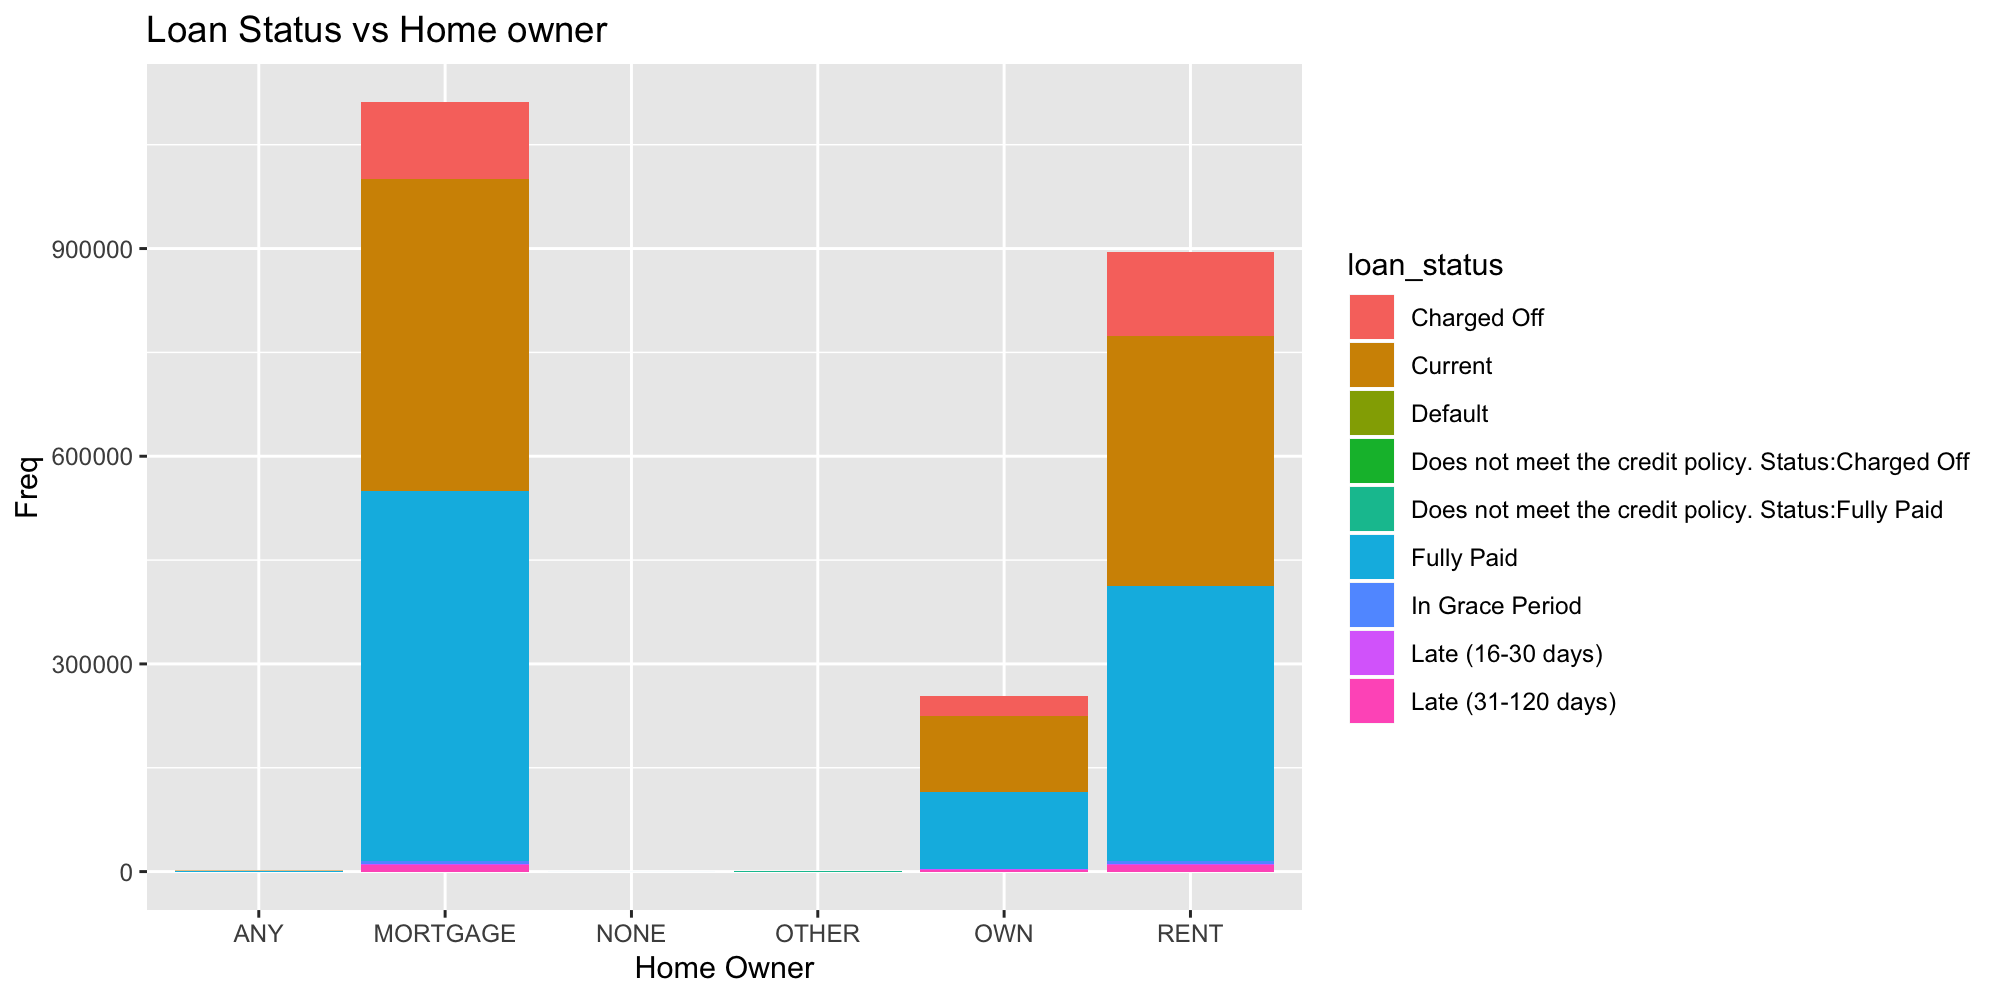

In [45]:
%%R -w 10 -h 5 --units in -r 200

ggplot(data = data, aes(x = home_ownership, fill = loan_status)) +
geom_bar() +
ggtitle("Loan Status vs Home owner") +
xlab("Home Owner") +
ylab("Freq")

Homeowners with mortgages, those who own homes and renters all have a similar breakdown in terms of the average status of their loans. Around 45 % of the loan statues are current, and the other 45% are fully paid off. The remining 10% of loans are "charged off", which means the loans were defaulted, or in other words, the individuals were unable to pay the loans. The category of renters have the highest percent of loans that are charged off/defaulting, indicating to investors that renters have the highest risk of defaulting.

R[write to console]: Warning:
R[write to console]:  Ignoring unknown aesthetics: method

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



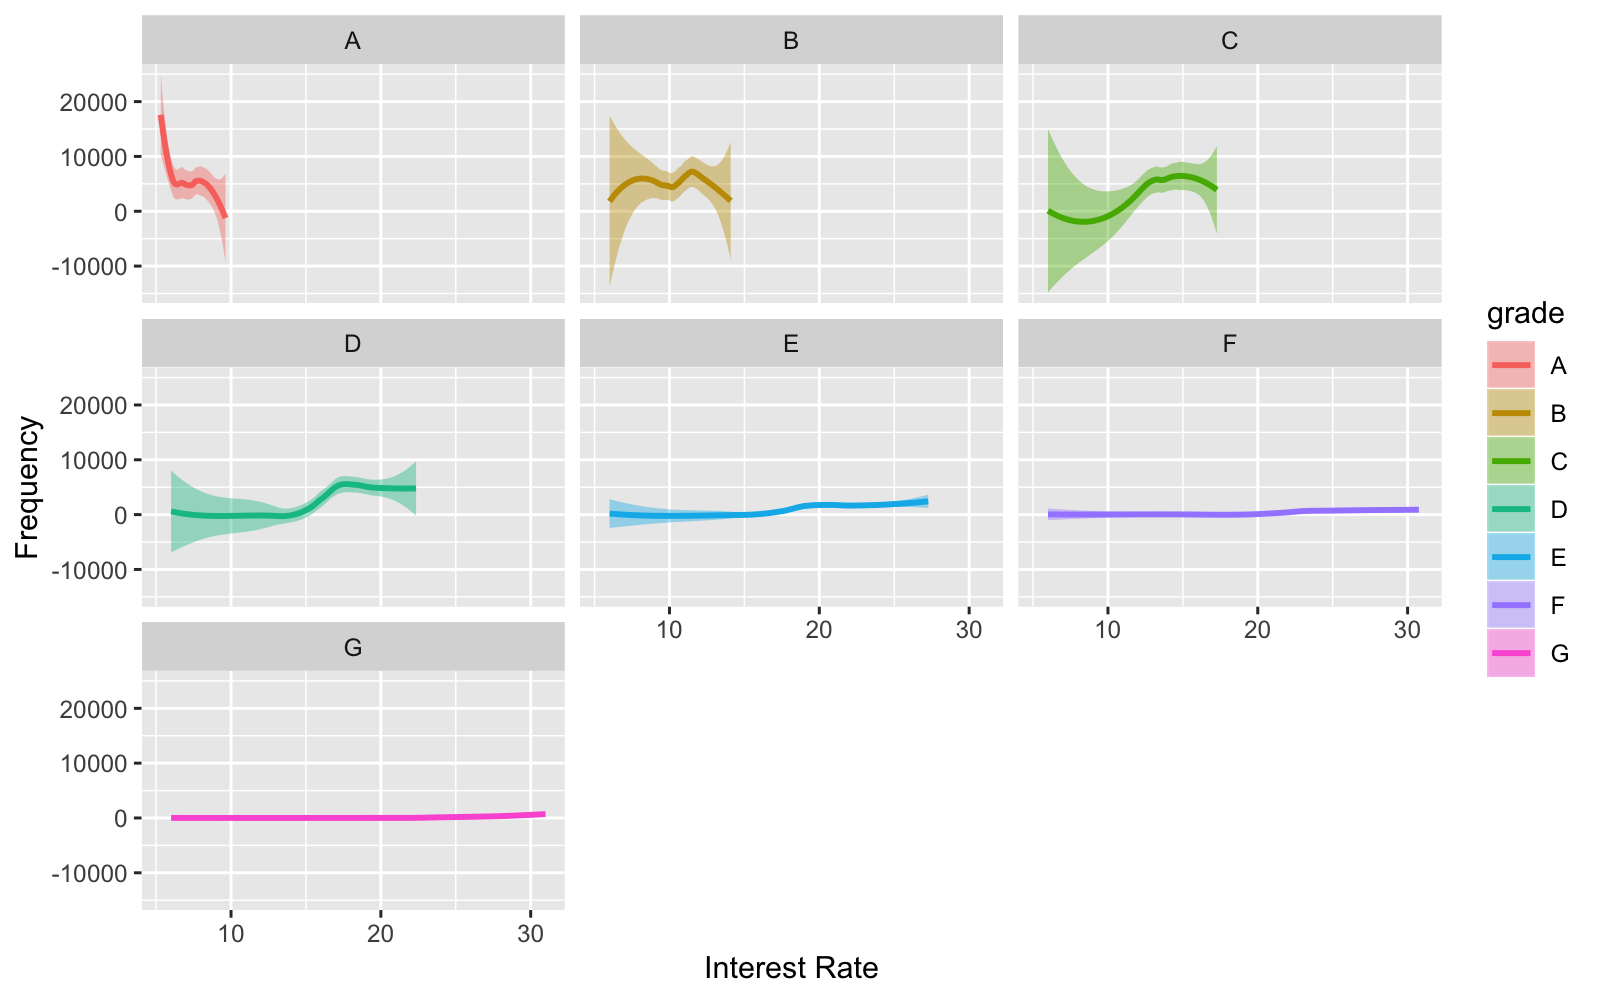

In [100]:
%%R -w 8 -h 5 --units in -r 200

c <- group_by(data, int_rate, grade) %>% dplyr::count(int_rate, grade) %>% set_colnames(c("interest", "grade", "count"))
ggplot(data = c, aes(x = interest, y = count)) +
geom_smooth(aes(colour = grade, fill = grade, method = "loess")) +
facet_wrap(~grade) +
labs(x = "Interest Rate", y = "Frequency")

# we can see the interest rate in G and F grade is the most distributed which the
# interest rate fall at 6.63 and 6.62

Here, we see a plot of the interest rate and the frequencies. The grade A loans have the highest frequency of loan interest rate loans, and as the interest rates decrease, the loans frequency decreases. For grades higher thatn D letter, the frequency of loans with different interest rates vary a lot. But laons of E, F and G have almost a constant frequency of loans for different interest rates. In other words there are almost equal numbers of loans of all types of interest rate levels.

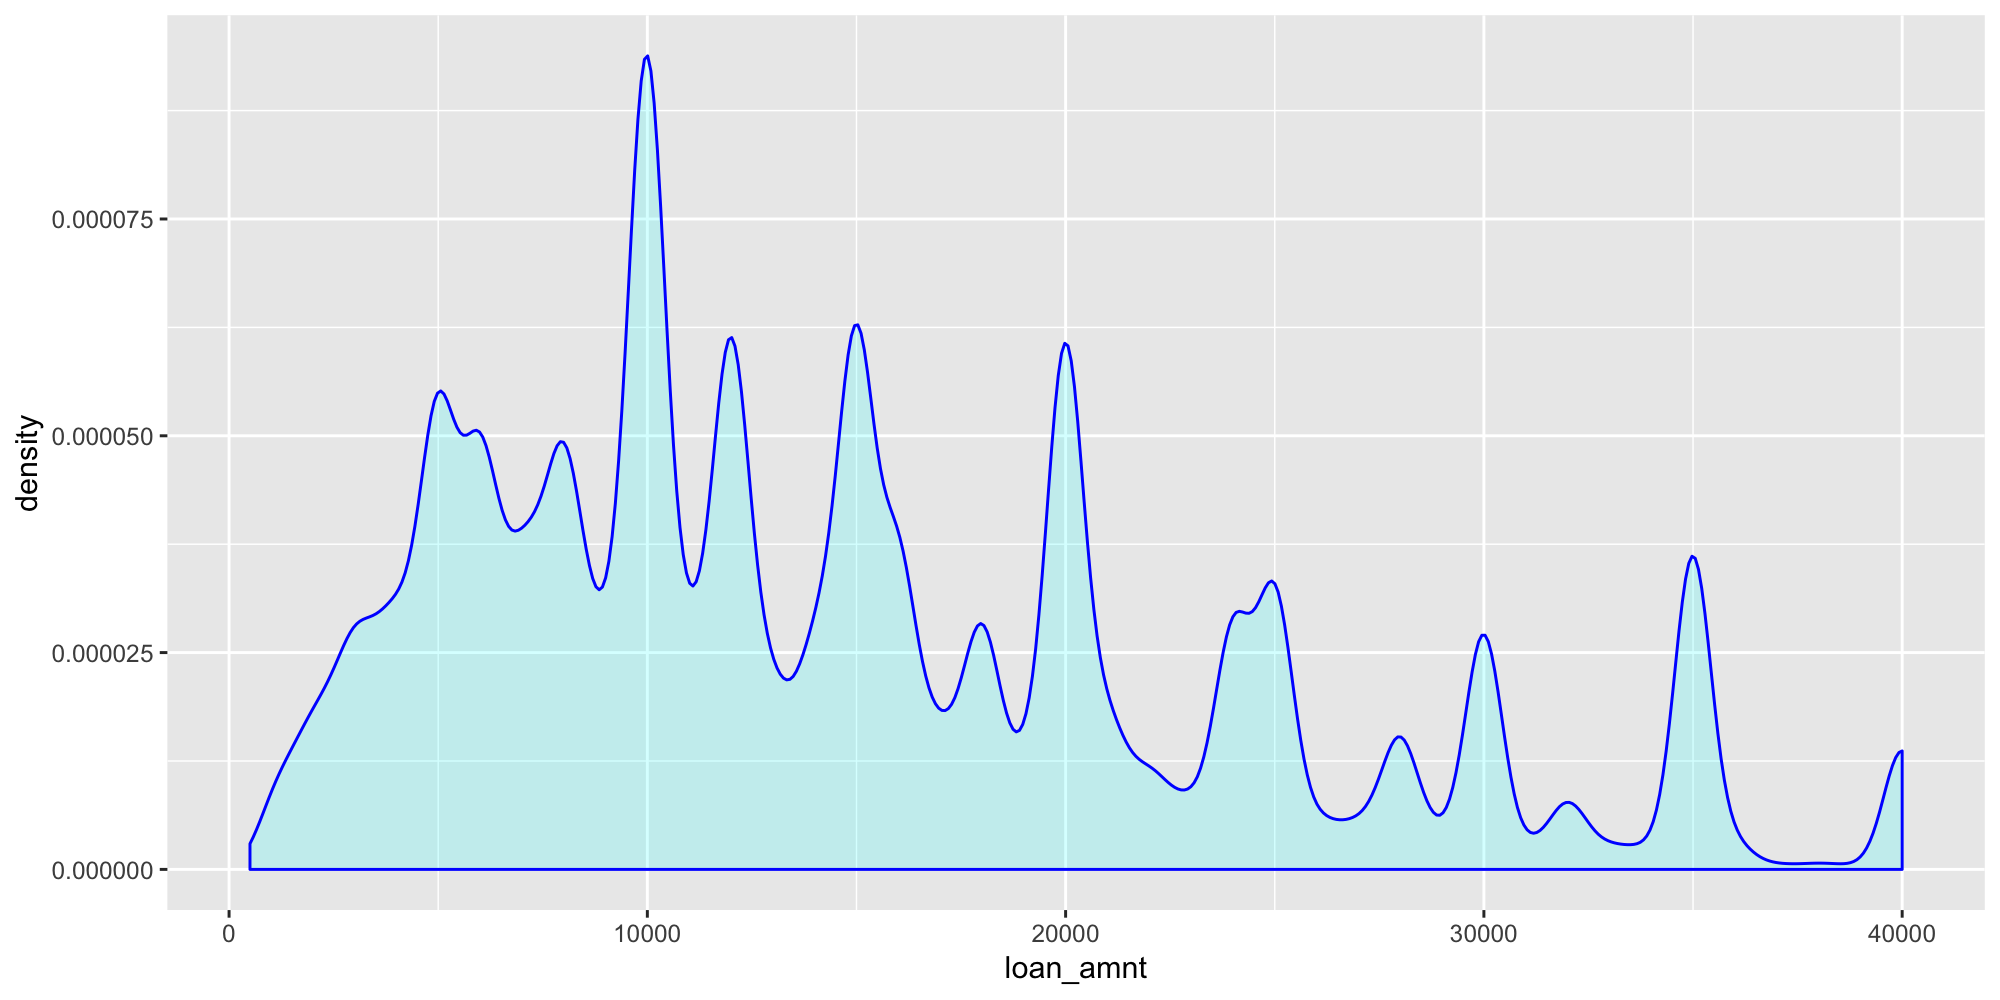

In [47]:
%%R -w 10 -h 5 --units in -r 200

ggplot(data = data, aes(loan_amnt)) +
geom_density(color = "blue", fill = "cyan", alpha = 0.2)

Here is a plot of the loan amounts and the density distribution of them . Based on the plot, the highest loan amount requested is 100,000. The shape of the graph is skewed right, signalling most of the loans requested are relatively small. There are many dips and curves in the graphs, signaling it is difficult to predict the density of different loan amounts. 

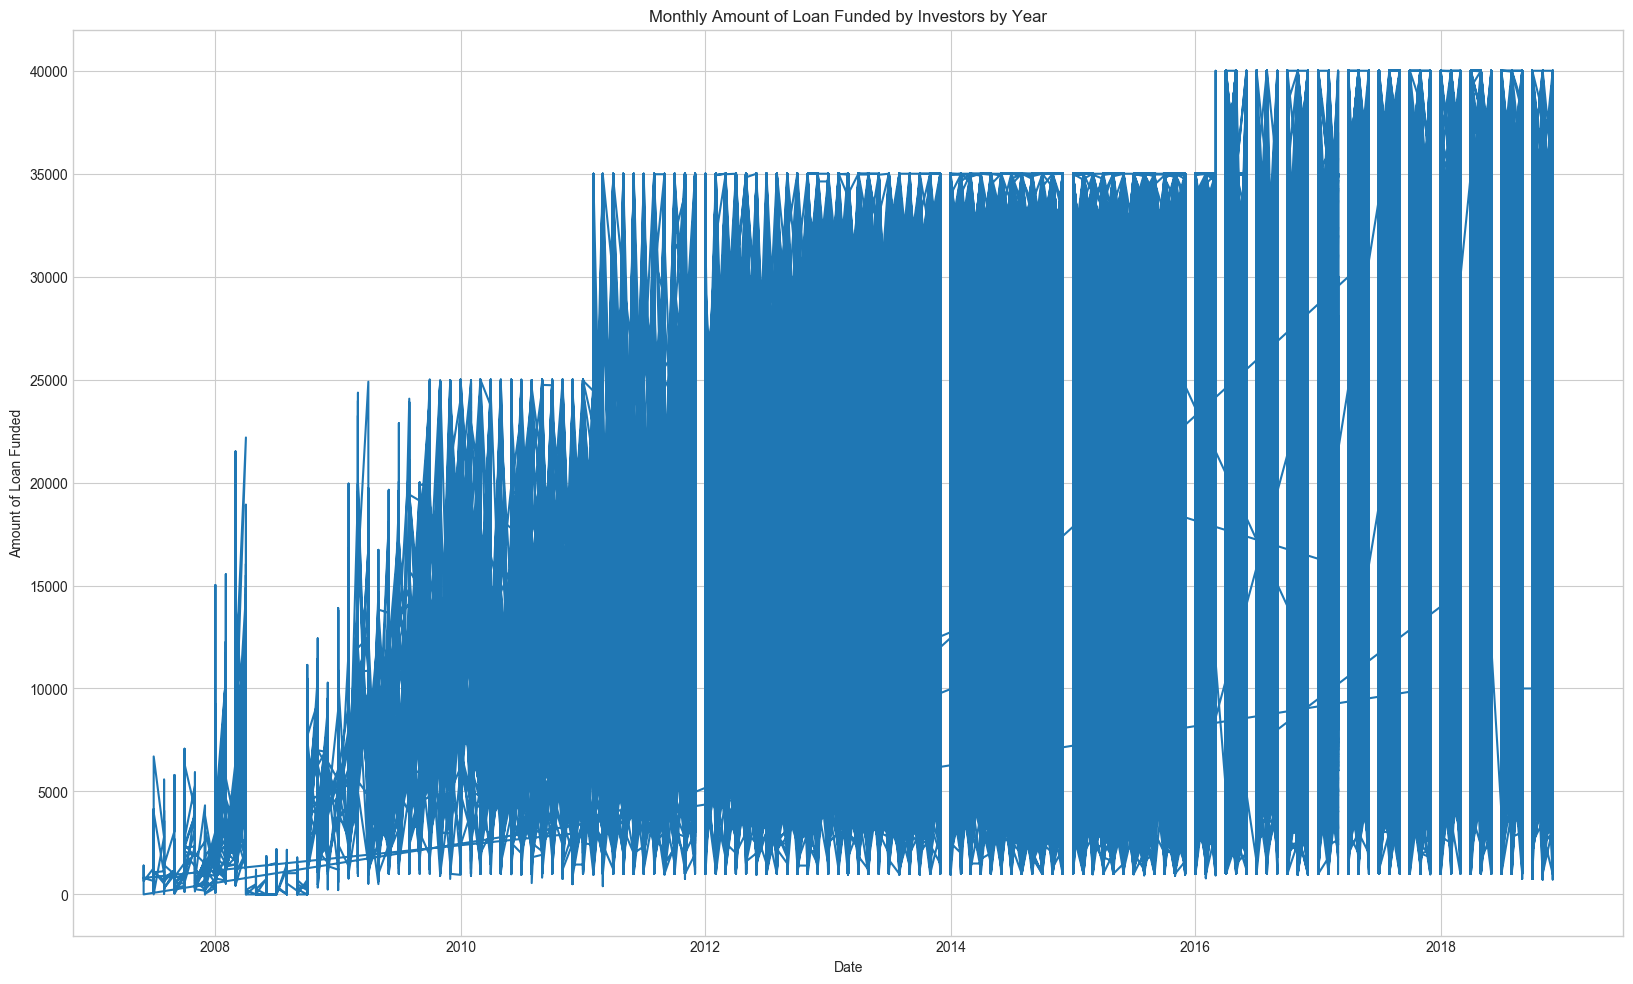

In [2]:
new_data = data.loc[:, ["funded_amnt_inv"]]
new_data = new_data.set_index(data["issue_date"])

plt.rcParams["agg.path.chunksize"] = 300000
plt.figure(figsize = (20,12), dpi = 100)
plt.plot(new_data.index, new_data["funded_amnt_inv"])
plt.xlabel("Date")
plt.ylabel("Amount of Loan Funded")
plt.gca().set(title="Monthly Amount of Loan Funded by Investors by Year")
plt.show()

The following graph is the amount of loans funded overtime strating from 2007 until 2018. There is an increase in the amounts of loan funded from 2011-2015 and another sudden increase at the year 2016. Notable is the gap of amount of loans funded around the year 2009.

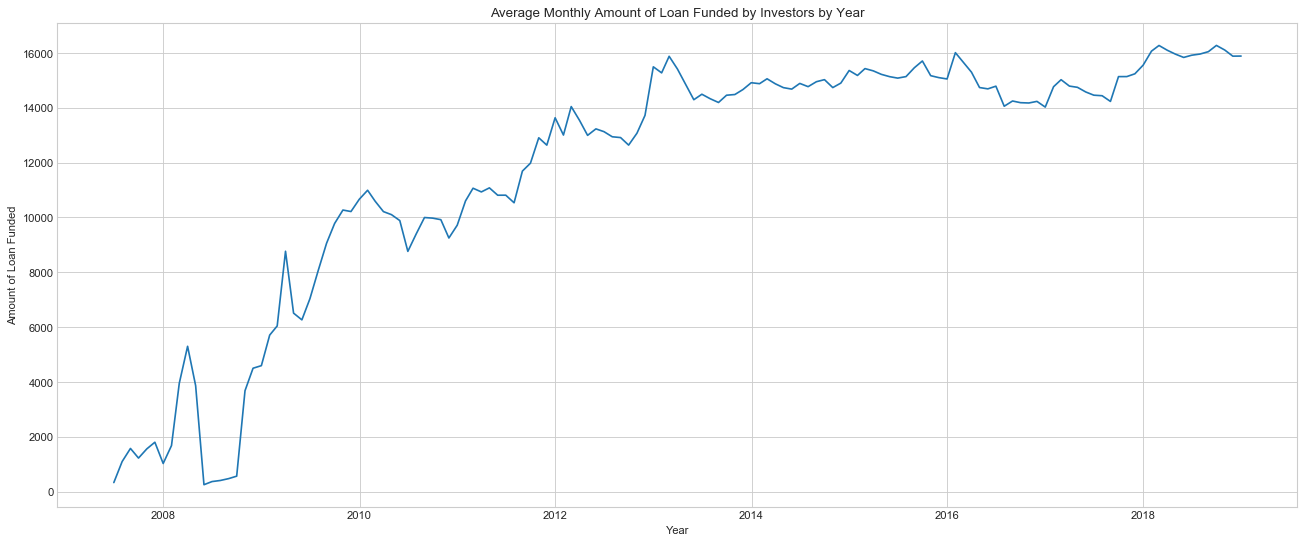

In [3]:
monthly = new_data.resample("M").mean()
plt.figure(figsize=(20,8), dpi=80)
plt.plot(monthly.index, monthly["funded_amnt_inv"], label = monthly.index)
plt.xlabel("Year")
plt.ylabel("Amount of Loan Funded")
plt.gca().set(title="Average Monthly Amount of Loan Funded by Investors by Year")
plt.show()

Here is the line graph of the amount of loans funded over the years. The year 2009 shows a stark dip in the loans funded (consistent with the graph above as well). Aft that the number of loans funded almost expoenitally increases from 2009 to 2013, and then plateus after that form 2013-2018.

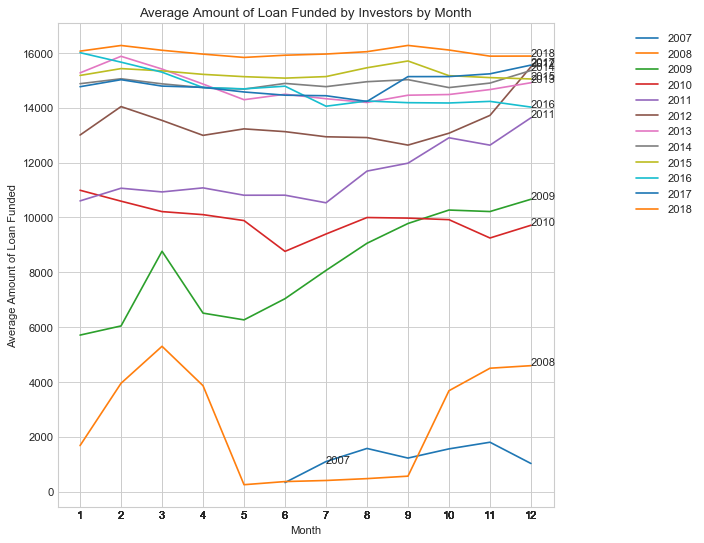

In [4]:
monthly["month"] = np.array([a.month for a in monthly.index])
monthly["year"] = np.array([a.year for a in monthly.index])
years = monthly["year"].unique()

plt.figure(figsize = (8,8), dpi = 80)
for i, y in enumerate(years):
    plt.plot("month", "funded_amnt_inv", data=monthly.loc[monthly.year == y, :], label=y)
    plt.text(monthly.loc[monthly.year == y, :].shape[0], monthly.loc[monthly.year == y, "funded_amnt_inv"][-1: ].values[0], y)
plt.xticks(monthly.month)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.gca().set(title = "Average Amount of Loan Funded by Investors by Month")
plt.xlabel("Month")
plt.ylabel("Average Amount of Loan Funded")
plt.show()

The above graph shows the average amount of loans funded by different investors over the months for different years. There were not many notable trends by month, but the years of 2008 and 2009 show similar patterns of an increase in loans funded from February to March followed by a decrease in March and April, and a steady increase from May. The years from 2011, 2013, 2012, 2016, 2017, 2018 all have very similar patterns and were on the top of the chart with an average amount of loan funded of 14000-16000. The years of 2007, 2008, and 2009 show the most variability in average amount of loans funded.

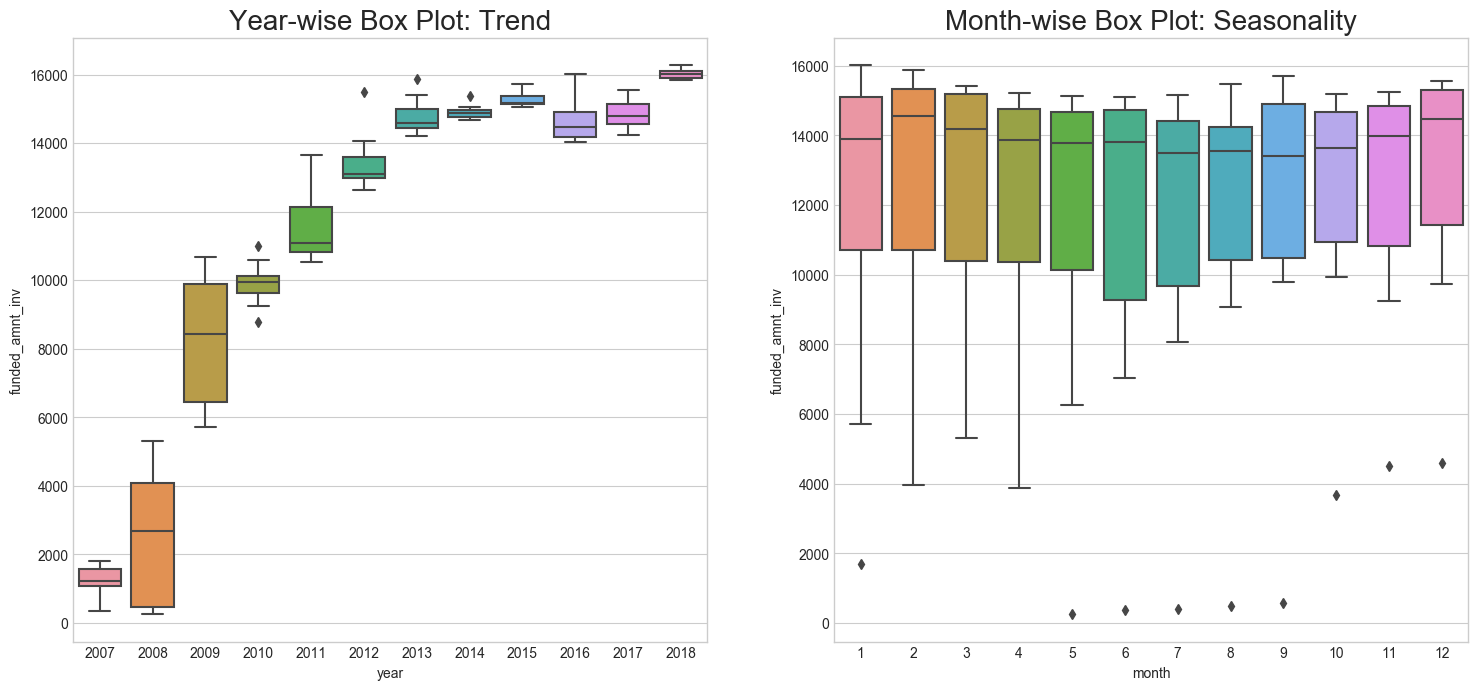

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(18,8), dpi=100)
sns.boxplot(x="year", y="funded_amnt_inv", data=monthly, ax=axes[0])
sns.boxplot(x="month", y="funded_amnt_inv", data=monthly.loc[~monthly["year"].isin([2007, 2018]), :])
axes[0].set_title("Year-wise Box Plot: Trend", fontsize=20)
axes[1].set_title("Month-wise Box Plot: Seasonality", fontsize=20)
plt.show()

Based on the Year-wise plot above, we can see that the average amount of loans kept rising from 2007 to 2015, but then fell from 2015 to 2016. This is most likely because the Federal Reserve raised its loan interest rate up by 0.25% in 2015-2016, causing  people borrowing loans as well as the amount of loans requested to decrease. Moreover, the loan amounts decreased starting in March that year based on the first plot because the first interest rate increase happened in March.

## Time Series Decomposition

We now look to model the data as a time series, with respect to the average amount of loans requested per month over time. We do this to predict when demand will spike as well as when demand will fall in the future.

There are different components to a time series:
* Trend: Increasing or decreasing value in the data
* Seasonality: Repeated cycles in the data
* Noise: Random variation in the data

With time series decomposition, we look to decompose a time series into these different components. There are two types of decompositions:
* Multiplicative Time Series Decomposition: Linear addition of trend, seasonality, and noise
* Additive Time Series Decomposition: Product of trend, seasonality, and noise (nonlinear)

We conduct both these decompositions in our analysis.

### Multiplicative Time Series Decomposition

<Figure size 1000x1000 with 0 Axes>

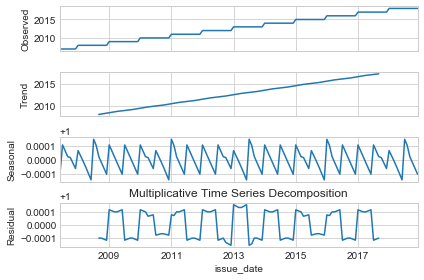

In [6]:
plt.figure(figsize=(10,10), dpi=100)
mul_ts = seasonal_decompose(monthly.year, model="multiplicative", freq=30)
mul_ts.plot()
plt.title("Multiplicative Time Series Decomposition")
plt.show()

### Additive Time Series Decomposition

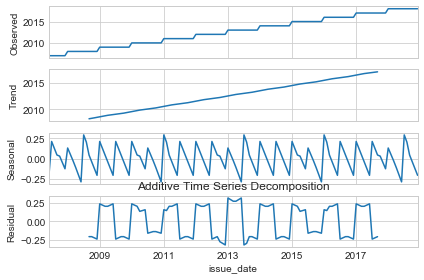

In [7]:
add_ts = seasonal_decompose(monthly.year, model="additive", freq=30)
add_ts.plot()
plt.title("Additive Time Series Decomposition")
plt.show()

## Data Wrangling

Before we jump in, we will have to first wrangle our data into a usable format.

We are starting off with 30 artibrarily selected variables out of the ~150 variables present in the dataset. Through wrangling, we will attempt to wittle that number down even more to reduce the dimensionality of the ensuing optimization problems.

### NA Values

We will first look at NA values and see if there are any variables that are primarily sparse. These variables will not be useful to us due to the lack of data, and as such, we can get rid of them.

In [31]:
print(data.shape)

(2260668, 30)


In [11]:
data_noNA = data.dropna()
print(data_noNA.shape)

(77054, 30)


Deleting rows that have any NA values results in 2753 rows in the end. This is a major loss of data, and as such, we should find another way to weed out these NA values.

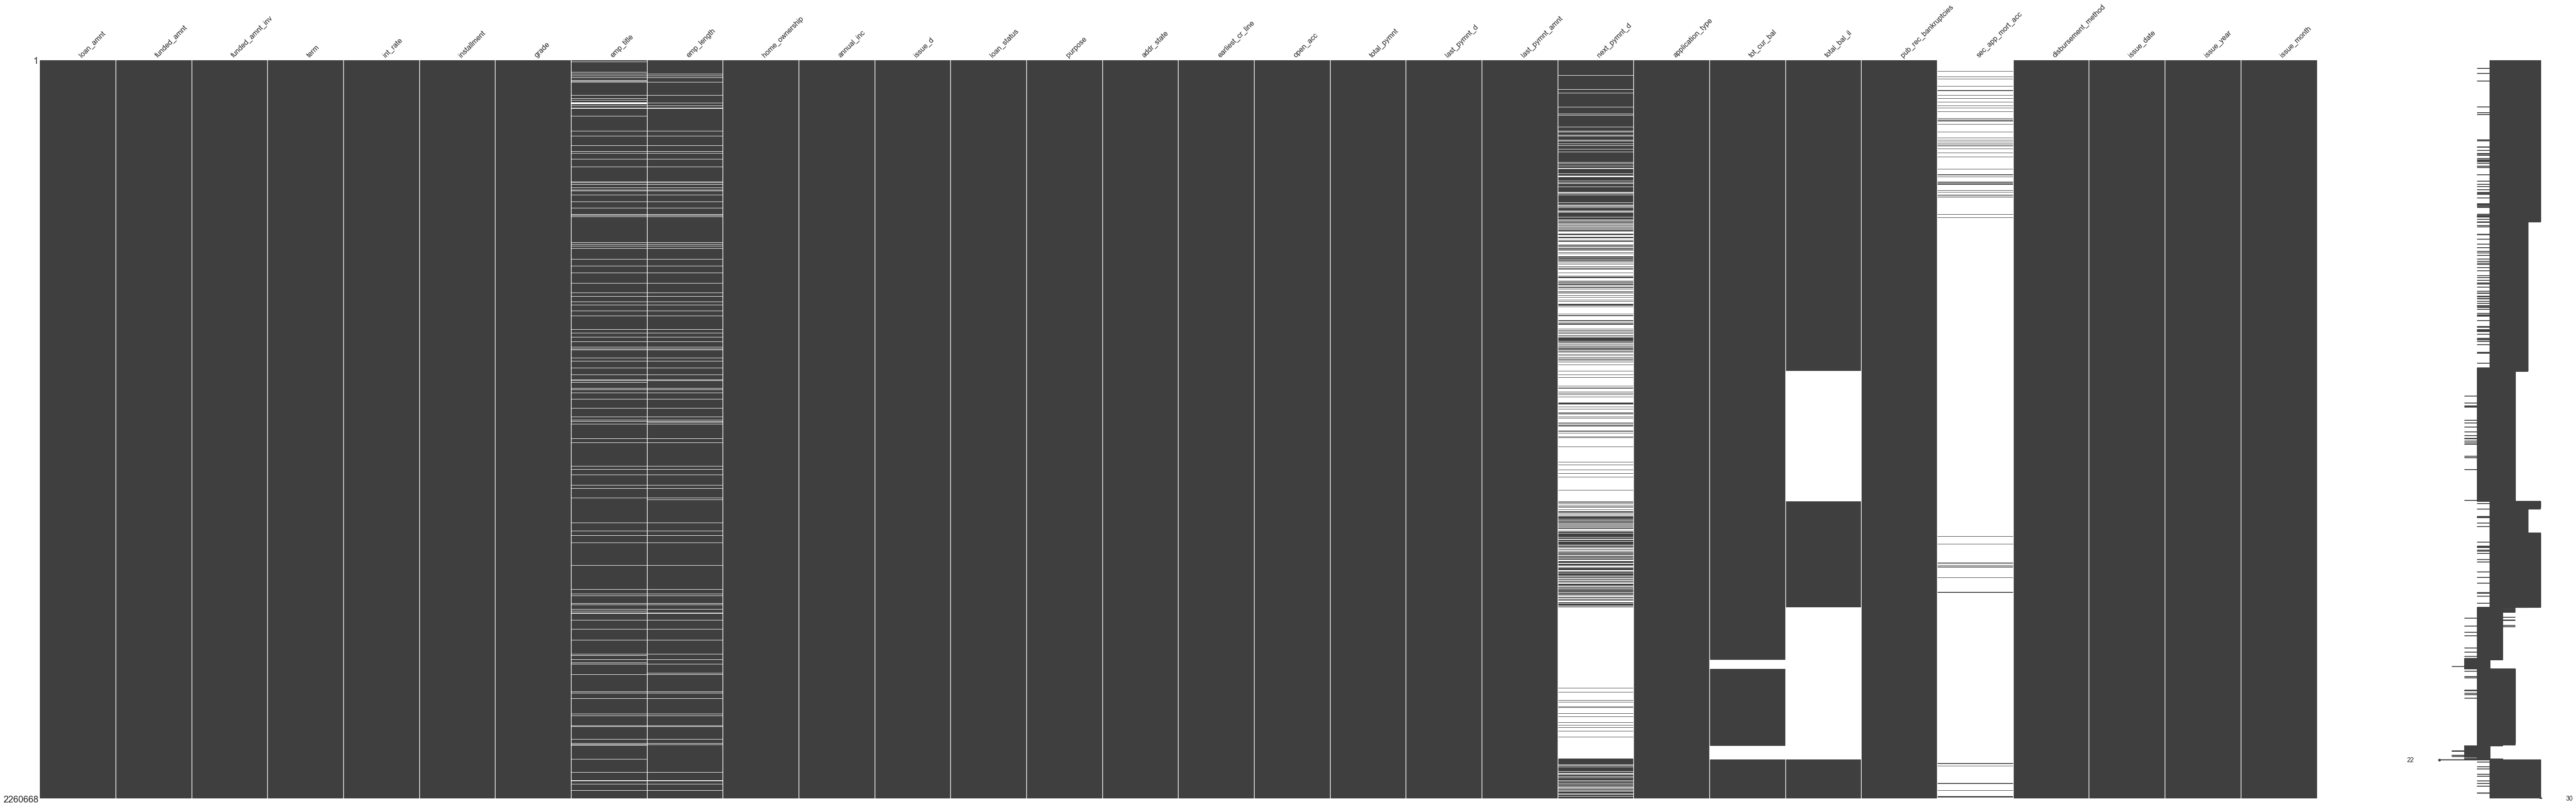

In [12]:
missingno.matrix(data, figsize=(100, 30))

In [9]:
data.isna().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
emp_title                166969
emp_length               146907
home_ownership                0
annual_inc                    4
issue_d                       0
loan_status                   0
purpose                       0
addr_state                    0
earliest_cr_line             29
open_acc                     29
total_pymnt                   0
last_pymnt_d               2426
last_pymnt_amnt               0
next_pymnt_d            1303607
application_type              0
tot_cur_bal               70276
total_bal_il             866129
pub_rec_bankruptcies       1365
sec_app_mort_acc        2152647
disbursement_method           0
issue_date                    0
issue_year                    0
issue_month                   0
dtype: int64

The table above gives the count of the number of missing NA values. This table and well as the graph indicate that there are three variables with most of its data missing: next payment date, total_bal_il, and sec_app_mort_acc.

We will get rid of these three and then repeat the step of deleting any resulting rows with NA values.

In [74]:
data1 = data.drop(["next_pymnt_d", "total_bal_il", "sec_app_mort_acc"], axis=1)
data1.shape

(2260668, 27)

In [75]:
data1_noNA = data1.dropna()
data1_noNA.shape

(2024994, 27)

We see that a lot more of the rows persisted after we deleted the three sparse variables, enough to fit models around.

### One Hot Encoding

Our next step will be to one hot encode all nominal variables since prediction models usually only work with strictly numerical data.

In [76]:
dummy_variables = ["issue_month", "emp_length", "term", "grade", "home_ownership", "purpose", "addr_state", "application_type", "disbursement_method"]
data_dummies = pd.get_dummies(data1_noNA[dummy_variables])
data_dummies.shape

(2024994, 96)

We now concat the variables from before with the one hot encoded variables, making sure to drop any redundant variables in the process.

We will elect to not one hot encode employment title and drop it altogether, since it takes on 512,698 different values.

Total payment is something we will not know from new customers, so we will remove this as well.

Other variables we will remove include datetime data points since they are hard to work with: last payment date, earliest credit line, and issue date.

In [77]:
data2_noNA = pd.concat([data1_noNA, data_dummies], axis=1)
data2_noNA = data2_noNA.drop(dummy_variables, axis=1)
data2_noNA = data2_noNA.drop(["emp_title", "total_pymnt", "last_pymnt_d", "earliest_cr_line", "issue_d", "issue_date"], axis=1) # data
data2_noNA.shape

(2024994, 107)

### Normalization

We should normalize the scales of the variables to be the same, so that the weights in the incoming prediction models could be more aptly compared with each other.

In [78]:
scaler = MinMaxScaler()
variables_to_normalize = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "last_pymnt_amnt", "installment", "annual_inc", "open_acc", "tot_cur_bal", "pub_rec_bankruptcies", "issue_year"]
data2_noNA[variables_to_normalize] = scaler.fit_transform(data2_noNA[variables_to_normalize])

## Correlation

We now investigate the correlation of the variables with each other.

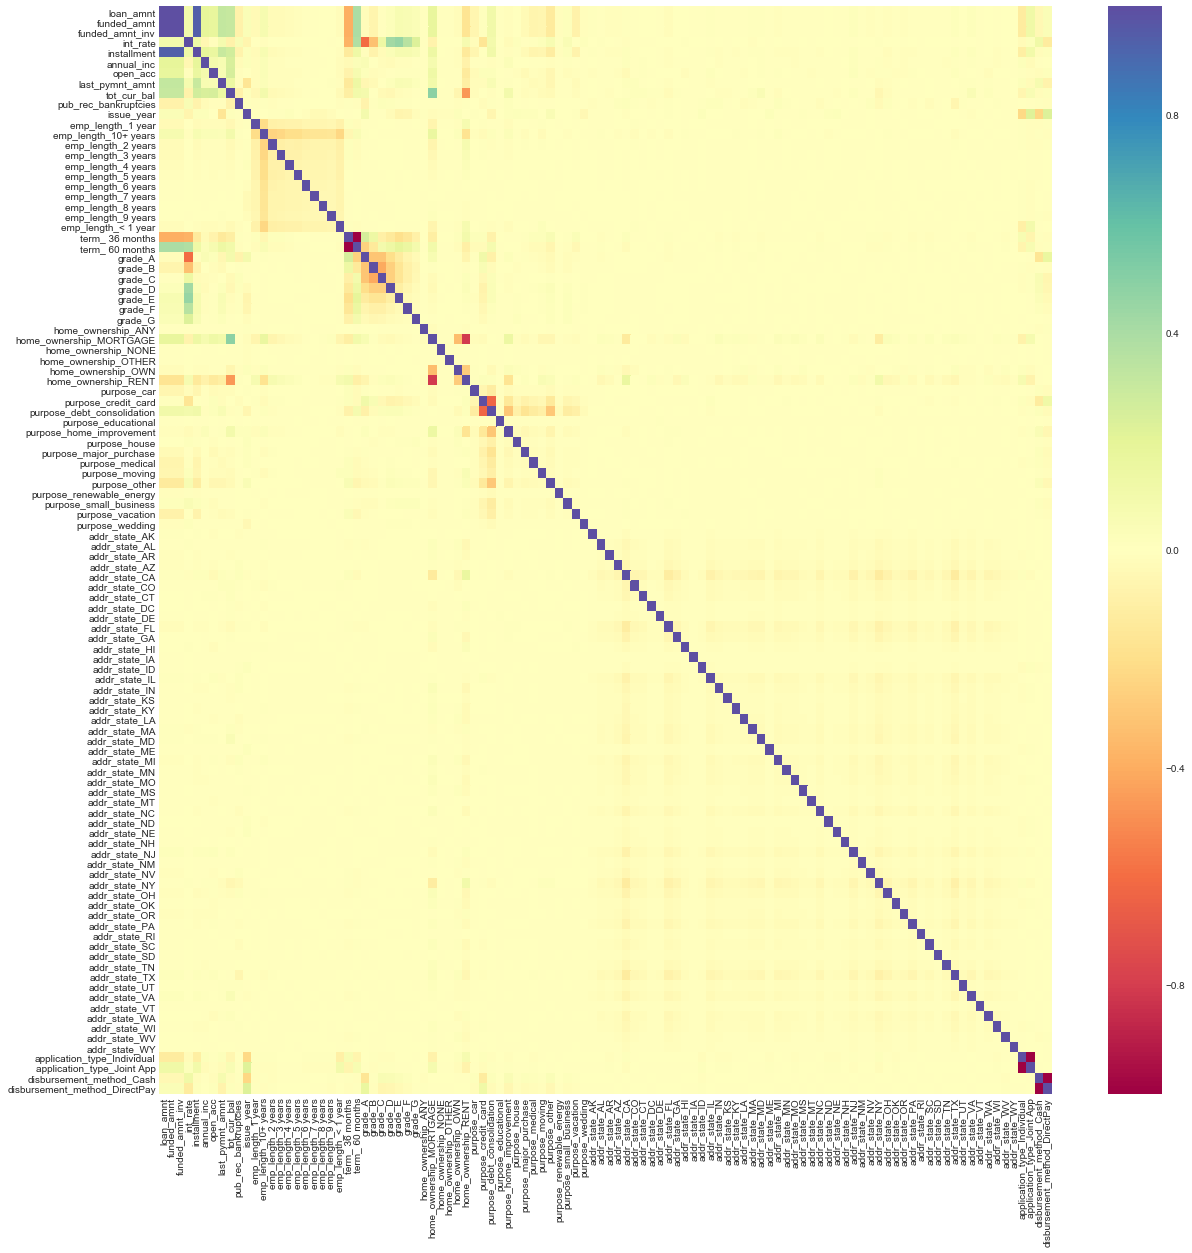

In [19]:
corr = data2_noNA.corr()
fig, ax = plt.subplots(figsize=(20, 20)) 
sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values, cmap="Spectral", ax=ax)

## Predicting whether the client's request should be funded or not

First, let us look at what the possible different statuses are in regards to a loan:

* Charge off: the original creditor has given up on being repaid according to the original terms of the loan. It considers the remaining balance to be bad debt, but that doesn't mean you no longer owe the amount that has not been repaid.
* In grace period: Still in time to pay but late
* Late: have not paid the full amount on time
* Current: in process
* Fully paid: Paid on time

For the purposes of creating a model we will remove current loans from our data since we do not know if they will be successfully paid off or not.

To be able to categorize this model, we will treat the status of loan of the remaining rows as:

If the loan is fully paid we will assign it the category 1 and if the loan is in a status of anything else, we will assign it the category 0. This category will be our output variable, or the data point we are trying to predict.

We will be fitting a few different models to this problem - the one that performs the best will be our final model. We will be attempting to use Logistic Regression, K-Nearest Neighbors, Stochastic Gradient Descent, and Multi-layer Perceptron.

In [79]:
data3_noNA = data2_noNA.loc[1:250000, :]
data3_noNA = data3_noNA[data3_noNA["loan_status"] != "Current"]
data3_noNA["y"] = np.where(data3_noNA["loan_status"] == "Fully Paid", 1, 0)
data3_noNA = data3_noNA.drop("loan_status", axis=1)

data3_noNA.shape

(12433, 107)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c982b70>]],
      dtype=object)

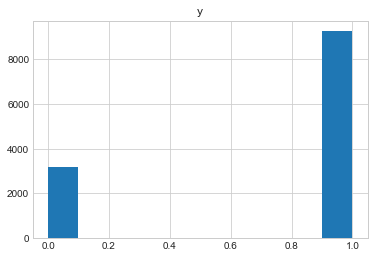

In [80]:
data3_noNA.hist(column='y')

In [81]:
y_train = data3_noNA.y
X_train = data3_noNA.drop(["y"], axis=1)

In [23]:
def fit_ml_algo(algo, X_train, y_train, cv):
    # one Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # cross validation 
    train_pred = model_selection.cross_val_predict(algo, X_train, y_train, cv=cv, n_jobs = -1)
    
    # cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

In [24]:
# Logistic Regression
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), X_train, y_train, 10)

print("Accuracy:", acc_log)
print("Accuracy CV 10-Fold:", acc_cv_log)

Accuracy: 92.25
Accuracy CV 10-Fold: 91.76


In [27]:
# K-Nearest Neighbors
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), X_train, y_train, 10)

print("Accuracy:", acc_knn)
print("Accuracy CV 10-Fold:", acc_cv_knn)

Accuracy: 83.99
Accuracy CV 10-Fold: 76.47


In [25]:
# Stochastic Gradient Descent
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), X_train, y_train, 10)

print("Accuracy:", acc_sgd)
print("Accuracy CV 10-Fold:", acc_cv_sgd)

Accuracy: 91.93
Accuracy CV 10-Fold: 83.32


In [82]:
# Random Forests
rf = RandomForestClassifier(n_estimators=400, max_depth=2, random_state=0)
train_pred_rf, acc_rf, acc_cv_rf = fit_ml_algo(rf, X_train, y_train, 10)

print("Accuracy:", acc_rf)
print("Accuracy CV 10-Fold:", acc_cv_rf)

Accuracy: 74.33
Accuracy CV 10-Fold: 74.33


In [26]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# Multi-layer Perceptron
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1,activation='logistic')
mlp.fit(X_train1, y_train1)

print("Training set score: %f" % mlp.score(X_train1, y_train1))
print("Test set score: %f" % mlp.score(X_test1, y_test1))
print(mlp.classes_)

Iteration 1, loss = 0.56877351
Iteration 2, loss = 0.56414833
Iteration 3, loss = 0.56049274
Iteration 4, loss = 0.55272172
Iteration 5, loss = 0.54044784
Iteration 6, loss = 0.52293632
Iteration 7, loss = 0.50444246
Iteration 8, loss = 0.49347459
Iteration 9, loss = 0.47685803
Iteration 10, loss = 0.46391952
Iteration 11, loss = 0.46680451
Iteration 12, loss = 0.45600086
Iteration 13, loss = 0.44868499
Iteration 14, loss = 0.44904909
Iteration 15, loss = 0.44540613
Iteration 16, loss = 0.45187672
Iteration 17, loss = 0.45336770
Iteration 18, loss = 0.52341831
Iteration 19, loss = 0.49695969
Iteration 20, loss = 0.48856730
Iteration 21, loss = 0.52200344
Iteration 22, loss = 0.57089873
Iteration 23, loss = 0.57031922
Iteration 24, loss = 0.57095135
Iteration 25, loss = 0.57095183
Iteration 26, loss = 0.57014146
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training set score: 0.743457
Test set score: 0.743115
[0 1]


We can see that the model with the best performance is given through Logistic Regression which gives us 91.8% accuracy.

In [85]:
rf.fit(X_train, y_train) 

feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances[1:20]

,importance
int_rate,0.120967
grade_A,0.108259
installment,0.061107
grade_D,0.059611
loan_amnt,0.057280
funded_amnt_inv,0.050823
home_ownership_RENT,0.047127
funded_amnt,0.042651
home_ownership_MORTGAGE,0.027318
tot_cur_bal,0.026442


## Predicting Interest Rate

In [63]:
data3_noNA = data2_noNA.loc[1:350000, :]
data3_noNA = data3_noNA.drop("loan_status", axis=1)

data3_noNA_train = data3_noNA.loc[1:250000, :]
data3_noNA_test = data3_noNA.loc[250000:350000, :]

In [64]:
y_train2 = data3_noNA_train.int_rate
X_train2 = data3_noNA_train.drop("int_rate", axis=1)

reg = MLPRegressor(hidden_layer_sizes=(10,)*10,  activation='relu', solver='lbfgs', alpha=0.001, batch_size='auto',
    learning_rate='adaptive', learning_rate_init=0.01,  max_iter=200, shuffle=True, random_state=1)
reg = reg.fit(X_train2, y_train2)

pred = list(reg.predict(X_train2))

sum_sigma = sum(abs(y_train2 - pred))
sum_sigma / len(pred)

0.8924177684544554

In [65]:
y_test2 = data3_noNA_test.int_rate 
X_test2 = data3_noNA_test.drop("int_rate", axis=1)

pred = list(reg.predict(X_test2))

sum_sigma = sum(abs(y_test2 - pred))
sum_sigma / len(pred)

1.0242064374447017

Through our Multi-layer Perceptron regressor, we were able to obtain the following accuracies:

Train Mean Absolute Error: 0.892

Test Mean Absolute Error: 1.024

Permutation importance is a useful method that can show us the weights of the features that are most important in the model. For every column, it randomly shuffle it while leaving the target and all other columns in place, and observes how much the accuracy of predictions decrease in the now shuffled data.

It is important to note that this permutation importance only tells us the most important features for our model. This does not mean that these features are the most important in general since since we are using a black-box method in the form of a neural network. Our model utilizes these features to make accurate predictions, but other models could get similar or even better accuracy while using a different set of parameters.

In [66]:
imputer = SimpleImputer()
imputed_X_train2 = imputer.fit_transform(X_train2)
imputed_X_test2 = imputer.transform(X_test2)

perm = PermutationImportance(reg, random_state=1).fit(imputed_X_test2, y_test2)
eli5.show_weights(perm, feature_names = X_test2.columns.tolist())

Weight,Feature
1.8439 ± 0.0027,grade_A
0.8837 ± 0.0091,grade_B
0.2538 ± 0.0022,grade_C
0.0886 ± 0.0004,grade_E
0.0773 ± 0.0006,disbursement_method_Cash
0.0616 ± 0.0005,disbursement_method_DirectPay
0.0605 ± 0.0010,installment
0.0573 ± 0.0004,grade_F
0.0490 ± 0.0002,term_ 60 months
0.0383 ± 0.0003,application_type_Joint App


We can see that for our model, the loan grade is the most important feature to predict the interest rate. It is most likely the case, however, that the interest rate is a direct function of the grade. While the loan grade is a useful predictor, predicting interest rate while accounting for the grade is a trivial task due the strong relationship present between them.

In [67]:
X_train3 = X_train2.drop(['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G'], axis=1)

reg = reg.fit(X_train3, y_train2)

pred = list(reg.predict(X_train3))

sum_sigma = sum(abs(y_train2 - pred))
sum_sigma / len(pred)

2.771634672114425

In [68]:
X_test3 = X_test2.drop(['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G'], axis=1)

pred = list(reg.predict(X_test3))

sum_sigma = sum(abs(y_test2 - pred))
sum_sigma / len(pred)

2.8541967733713536

When we drop the loan grades from our model, the accuracy decreases to:

Train Mean Absolute Error: 2.772

Test Mean Absolute Error: 2.854

The most useful weights in this model are:

In [69]:
imputer = SimpleImputer()
imputed_X_train3 = imputer.fit_transform(X_train3)
imputed_X_test3 = imputer.transform(X_test3)

perm = PermutationImportance(reg, random_state=1).fit(imputed_X_test3, y_test2)
eli5.show_weights(perm, feature_names = X_test3.columns.tolist())

Weight,Feature
14.9085 ± 0.0647,installment
2.4221 ± 0.0263,funded_amnt_inv
2.0564 ± 0.0038,loan_amnt
1.9045 ± 0.0122,funded_amnt
0.9511 ± 0.0060,term_ 60 months
0.4839 ± 0.0048,term_ 36 months
0.1980 ± 0.0027,application_type_Joint App
0.1497 ± 0.0023,application_type_Individual
0.0186 ± 0.0006,home_ownership_MORTGAGE
0.0166 ± 0.0005,purpose_credit_card


In [70]:
X_train4 = X_train3.drop("installment", axis=1)

reg = reg.fit(X_train4, y_train2)

pred = list(reg.predict(X_train4))

sum_sigma = sum(abs(y_train2 - pred))
sum_sigma / len(pred)

3.6454943361438614

In [71]:
X_test4 = X_test3.drop("installment", axis=1)

pred = list(reg.predict(X_test4))

sum_sigma = sum(abs(y_test2 - pred))
sum_sigma / len(pred)

3.7577352334424865

When we drop installment from our model, the accuracy decreases to:

Train Mean Absolute Error: 2.645

Test Mean Absolute Error: 3.758

The most useful weights in this model are:

In [72]:
imputer = SimpleImputer()
imputed_X_train4 = imputer.fit_transform(X_train4)
imputed_X_test4 = imputer.transform(X_test4)

perm = PermutationImportance(reg, random_state=1).fit(imputed_X_test4, y_test2)
eli5.show_weights(perm, feature_names = X_test4.columns.tolist())

Weight,Feature
0.1821 ± 0.0025,term_ 60 months
0.0840 ± 0.0021,term_ 36 months
0.0349 ± 0.0018,disbursement_method_Cash
0.0203 ± 0.0006,purpose_credit_card
0.0187 ± 0.0011,home_ownership_RENT
0.0092 ± 0.0006,application_type_Joint App
0.0064 ± 0.0006,disbursement_method_DirectPay
0.0040 ± 0.0002,last_pymnt_amnt
0.0023 ± 0.0001,purpose_home_improvement
0.0016 ± 0.0003,home_ownership_OWN


So we can see that we start losing more acuracy after instalment and grade have been removed. so we can say these 2 are associated. so as long as we have one in our model we can have good estimates